The system was integrated for N > max(ht1, ht2) periods and then test stimuli of fixed intensity were applied.

In [19]:
CODE = '/Users/Lina/Documents/GitHub/habituation'

import sys, path, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

sys.path.append(CODE)
import system
from calc_util import sliding_maxnorm_ht
from adaint import integrate, default_steps_per_time, integrate2, default_h_max
  

#%% definitions

def control_experiment(f, p, X0, T, Ton, Amin, Amax, Atest=None, tsteps=None, N=20):
    
    # comment
    mys = system.System(f, p, X0, output_var_idx=-1, steps_per_time=100, hmax=0)
    mys.T = T
    mys.Ton = Ton
    mys.Amin = Amin
    mys.Amax = Amax
    
    if Atest is None:
        Atest = Amax
    
    
    ### apply N stimuli
    for i in range(0, N):
        # update initial condition and tvec
        if i==0:
            X = X0
            tvec_ = np.linspace(0, T, T*100)
        else:
            X = singlepeak_[-1, :]
            X[X < 0] = 0.0 
            tvec_ = np.linspace(tvec_[-1], tvec_[-1]+T, T*100)
            
        # integrate single stimulus
        _ , singlepeak_ = mys.apply_singlestimulus(X, T=T, Ton=Ton, Amin=Amin, Amax=Amax, 
                                                  tvec=None)
        if i==0:
            traj = singlepeak_
            tvec = tvec_
        else:    
            traj = np.concatenate([traj, singlepeak_])
            tvec = np.concatenate([tvec, tvec_])
    
    if tsteps is not None:
        ### apply control stimuli after habituation
        
        # this is needed to circumvent an error in integrate_posthabituation_atAmin
        mys.computational_data["habituation_time"] = N*T
        mys.computational_data["habituation_time_step"] = -1
        mys.computational_data['trajectory'] = traj
        
        # let the system recover
        tvec_, recov_ =  mys.integrate_posthabituation_atAmin(tend=500)
        
        mys.computational_data['recovery_trajectory'] = recov_

        
        # add stimuli at tsteps
        tend = tvec[-1]
        for i, tstep in enumerate(tsteps):
            
            X = mys.computational_data['recovery_trajectory'][tstep*100,:]
            X[X<0] = 0.0

            tvec_ = np.linspace(tstep, tstep+T, 100) + tend
                
            _ , singlepeak_ = mys.apply_singlestimulus(X, T=T, Ton=Ton, Amin=Amin, Amax=Atest, tvec=tvec_)

            if i==0:
                tvectest = tvec_
                trajtest = singlepeak_
            else:
                tvectest = np.concatenate([tvectest, tvec_])
                trajtest = np.concatenate([trajtest, singlepeak_])
            
        
    return [tvec, traj, tvectest, trajtest]


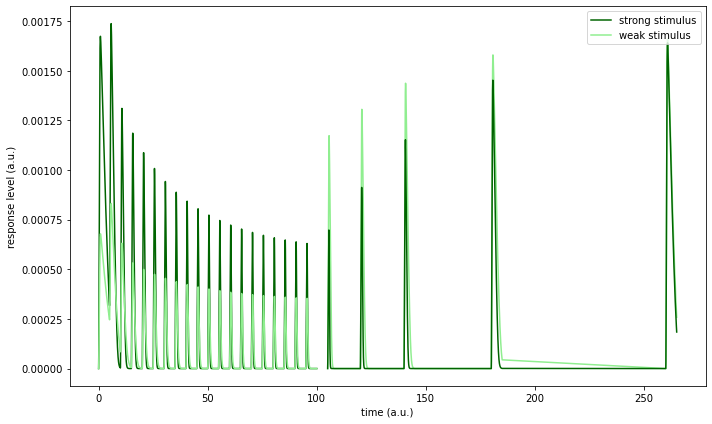

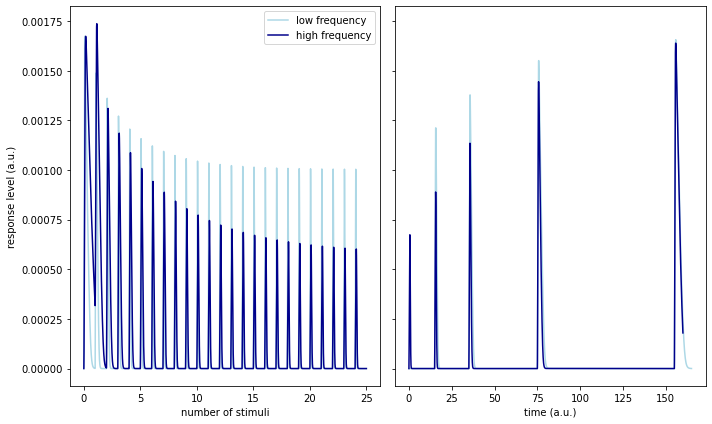

In [41]:
#%% SINGLE IFF MODEL
def f(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1):
    # starting values 
    I1, M1, R1 = X
    # ODEs\n",
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)

    return(dI1, dM1, dR1)

p =[ 0.21431239109526712, 6.847671424297533, 0.009953498338965153 , 0.024876350255001917, 0.011779374058405177, 0.30, 0.0002789402845197418] #only rates and ODE parameters\n",
Ton = 0.5
Amin = 0.0
Amax_low = 4.51
Amax_high = 13.52
Amax = 4.51
T_fast = 5
T_slow = 10
T = 5
X0 = [0,0,0] 

# INTENSITY SENSITIVITY
x1, y1, a1, b1 = control_experiment(f, p, X0, T, Ton, Amin, Amax_high, Atest=Amax_high, tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=20)
x2, y2, a2, b2 = control_experiment(f, p, X0, T, Ton, Amin, Amax_low, Atest=Amax_high, tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=20)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
ax.plot(x1, y1[:,-1], color='darkgreen', label='strong stimulus')
ax.plot(x2, y2[:,-1], color='lightgreen')
ax.plot(a2, b2[:,-1], color='lightgreen', label='weak stimulus')
ax.plot(a1, b1[:,-1], color='darkgreen')
plt.xlabel('time (a.u.)')
ax.set_ylabel('response level (a.u.)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


# FREQUENCY SENSITIVITY
x1, y1, a1, b1 = control_experiment(f, p, X0, T_fast, Ton, Amin, Amax_high, Atest=Amax_high, 
                                    tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=25)
x2, y2, a2, b2 = control_experiment(f, p, X0, T_slow, Ton, Amin, Amax_high, Atest=Amax_high, 
                                    tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=25)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax = axes[0]
ax.plot(x2/T_slow, y2[:,-1], color='lightblue', label='low frequency')
ax.plot(x1/T_fast, y1[:,-1], color='darkblue', label='high frequency')
ax.set_ylabel('response level (a.u.)')
ax.set_xlabel('number of stimuli')
ax.legend(loc='upper right')

ax = axes[1]
ax.plot(a2-a2[0], b2[:,-1], color='lightblue')
ax.plot(a1-a1[0], b1[:,-1], color='darkblue')
plt.xlabel('time (a.u.)')
plt.tight_layout()
plt.show()


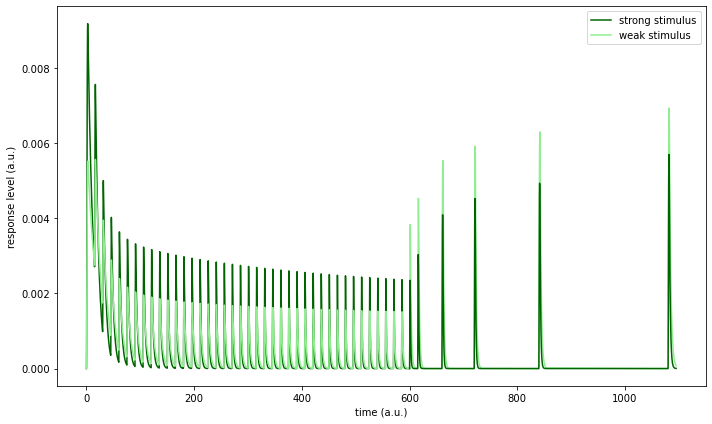

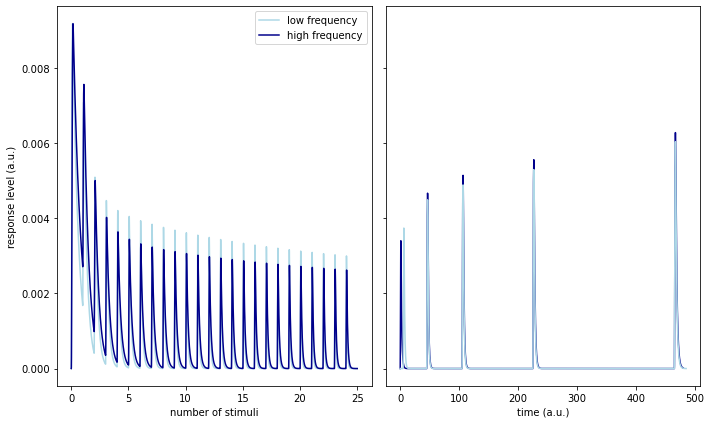

In [38]:
# CONCATENATED FEEDFORWARD
def f(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)

    return(dI1, dM1, dR1, dI2, dM2, dR2)

p = [ 0.023, 34.44, 17.7071, 0.038241, 57.9236, 1.39117, 0.000534, 
            0.016011, 14.3342,  4.33609, 0.001471, 26.1702, 45.9986, 0.79082] #only rates and ODE parameters
Ton = 0.5
Amin = 0.0
Amax_low = 10
Amax_high = 20
Amax = 10
T_fast = 15
T_slow = 20
T = 15
X0 = [0,0,0,0,0,0] 

# INTENSITY SENSITIVITY
x1, y1, a1, b1 = control_experiment(f, p, X0, T, Ton, Amin, Amax_high, Atest=Amax_high, tsteps=[0, T, 4*T, 8*T, 16*T, 32*T], N=40)
x2, y2, a2, b2 = control_experiment(f, p, X0, T, Ton, Amin, Amax_low, Atest=Amax_high, tsteps=[0, T, 4*T, 8*T, 16*T, 32*T], N=40)

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
ax.plot(x1, y1[:,-1], color='darkgreen', label='strong stimulus')
ax.plot(x2, y2[:,-1], color='lightgreen')
ax.plot(a2, b2[:,-1], color='lightgreen', label='weak stimulus')
ax.plot(a1, b1[:,-1], color='darkgreen')
plt.xlabel('time (a.u.)')
ax.set_ylabel('response level (a.u.)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


# FREQUENCY SENSITIVITY
x1, y1, a1, b1 = control_experiment(f, p, X0, T_fast, Ton, Amin, Amax_high, Atest=Amax_high, 
                                    tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=25)
x2, y2, a2, b2 = control_experiment(f, p, X0, T_slow, Ton, Amin, Amax_high, Atest=Amax_high, 
                                    tsteps=[T, 4*T, 8*T, 16*T, 32*T], N=25)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax = axes[0]
ax.plot(x2/T_slow, y2[:,-1], color='lightblue', label='low frequency')
ax.plot(x1/T_fast, y1[:,-1], color='darkblue', label='high frequency')
ax.set_ylabel('response level (a.u.)')
ax.set_xlabel('number of stimuli')
ax.legend(loc='upper right')

ax = axes[1]
ax.plot(a1-a1[0], b1[:,-1], color='darkblue')
ax.plot(a2-a2[0], b2[:,-1], color='lightblue')
plt.xlabel('time (a.u.)')
plt.tight_layout()
plt.show()


There is an important effect in the frequency sensitivity figure. Depending on when the test stimulus is applied, the ratio of response for low vs high freqency is reversed. This is due to the fact that for early test stimuli the first memory, which decays fast, is still present whereas for later stimuli the dynamics is determined by the second memory only. 
I think this is something worth discussing in the paper or SI since it questions the proposed t1-t2 control framework. (On a more general note I am a bit sceptical that the t1-t2 scenario really allows you to measure learning instead of performance. As long as you measure the response rather than the memory/internal state, aren't you always testing performance?)

In order to measure habituation without recovery effects as confounding factor I believe it would be best to apply the test stimulus right after habituation. Do you agree Rosa?